# Imports and Data Load

In [1]:
import math
from datetime import datetime, timedelta
from pathlib import Path
from custom_lib import data, stats, ml, vis
import pandas
pandas.set_option('display.float_format', '{:.7f}'.format)
from matplotlib import pyplot as plt
from pandas import DataFrame, Series
import numpy
from typing import Tuple
import random
random.seed(42)

from focusStepsPelmo.ioTypes.gap import FOCUSCrop, Scenario

"""Block load data"""

pandas.set_option('display.max_columns', None)
save_dir = Path('results') / "all_datasets"
data_parent = Path("data")
data_child = Path("samples.csv")
datasets = {
    #"tiny": "tiny",
    #"tiny2": "tiny",
    #"tiny3": "tiny",

    #"large": "combined-2025-06-05",
    "ppdb-gen": "new_setup", 
}#

In [2]:
test_data = Path('data', "ppdb_extrapolation",'new_ppdb_inferred.csv')
test_data = data.load_data(test_data)
data.all_augments(test_data)
data.feature_engineer(test_data)
test_data_filtered = data.remove_low_filter(test_data)
test_data_critical = data.between_filter(test_data)
test_data_filtered = test_data_filtered.sample(n=min(test_data_filtered.shape[0], 15_000))
test_data_critical = test_data_critical.sample(n=min(test_data_critical.shape[0], 15_000))
test_features, test_labels = ml.split_into_data_and_label(test_data_filtered)
test_features_critical, test_labels_critical = ml.split_into_data_and_label(test_data_critical)

# Transform Data Types

In [3]:
datasets = {name: data.load_data(data_parent / path / data_child) for name, path in datasets.items()}
for dataset in datasets.values():
    data.all_augments(dataset)
    data.feature_engineer(dataset)
    to_drop = [c for c in dataset.columns if c.startswith("metabolite")]
    dataset.drop(columns=to_drop, inplace=True)
datasets = {name: data.remove_low_filter(dataset) for name, dataset in datasets.items()}
datasets = {name: dataset.sample(n=min(dataset.shape[0], 10_000)) for name, dataset in datasets.items()}
datasets_train = {name: {"features": ml.split_into_data_and_label(dataset)[0], "labels": ml.split_into_data_and_label(dataset)[1]} for name, dataset in datasets.items()}

In [4]:
#datasets['large'].describe()

# Machine Learning

In [5]:
models = {}

## Model Definitions

### Linear Regression

In [6]:
from sklearn import linear_model
linear_regression = linear_model.LinearRegression()
models['Linear Regression'] = linear_regression

### Support Vector Machine

In [7]:
from sklearn import svm
support_vector_machine_parent = svm.SVR()
support_vector_machine_metabolite = svm.SVR()
models['Support Vector Machine'] = support_vector_machine_parent

### Decision Tree

In [8]:
from sklearn import tree
decision_tree = tree.DecisionTreeRegressor()
models['Decision Tree'] = decision_tree

### Random Forest

In [9]:
from sklearn.ensemble import RandomForestRegressor
random_forests = RandomForestRegressor(max_depth=11)
models['Random Forest'] = random_forests

### Gradient Boosting Ensemble

In [10]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
hist_gradient_boosting_parent = HistGradientBoostingRegressor()
hist_gradient_boosting_metabolite = HistGradientBoostingRegressor()
models['Gradient Boosting Ensemble'] = hist_gradient_boosting_parent

c:\Users\GPLCE\Documents\code\eEnSa-FocusSteps-Pelmo\venv\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:18: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


### Gaussian Process

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) #+ WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1)

# slow performance
models['Gaussian Process'] = gaussian_process

## Perceptron

In [12]:
from sklearn.neural_network import MLPRegressor
mlp_regressor = MLPRegressor(max_iter=1000)
models['Multi Layer Perceptron'] = mlp_regressor

### CatBoostRegressor

In [13]:
from catboost import CatBoostRegressor
cbr = CatBoostRegressor()
models['Cat Boost Regressor'] = cbr

## Scale Data

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import clone

scaler = StandardScaler()
models = {name: make_pipeline(clone(scaler), model) for name, model in models.items()}

In [15]:
from sklearn.metrics import r2_score

In [16]:
custom_metric = stats.make_custom_metric(greater_is_better=False)

# Crossvalidation

In [17]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer
import numpy as np
datasets_results = {}
for datasetname, dataset in datasets_train.items():
    datasets_results[datasetname] = {}
    print("-"*10, datasetname, "-"*10)
    cv = RepeatedKFold(n_repeats=5, n_splits=5)
    for name, model in models.items():
        print(name, end=" ")
        result = cross_validate(model, dataset['features'], dataset['labels'], 
                                scoring={"R²": make_scorer(r2_score), "RMSE": make_scorer(stats.root_mean_squared_error), "Custom Metric": make_scorer(custom_metric)},
                               cv=cv)
        print("finished")
        result = {key[5:]: value for key, value in result.items() if key.startswith("test_")}
        for metric, scores in result.items():
            mean = np.mean(scores)
            std = np.std(scores)
            print(f"{metric:<6} {mean=:.2f} {std=:.2f}")
        datasets_results[datasetname][name] = result
        print()

        


---------- ppdb-gen ----------
Linear Regression finished
R²     mean=-0.68 std=1.30
RMSE   mean=1.36 std=0.46
Custom Metric mean=4.55 std=2.57

Support Vector Machine 

c:\Users\GPLCE\Documents\code\eEnSa-FocusSteps-Pelmo\venv\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\GPLCE\Documents\code\eEnSa-FocusSteps-Pelmo\venv\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\GPLCE\Documents\code\eEnSa-FocusSteps-Pelmo\venv\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\GPLCE\Documents\code\eEnSa-FocusSteps-Pelmo\venv\lib\site-packages\sklearn\utils\validation.py

finished
R²     mean=0.15 std=0.05
RMSE   mean=1.03 std=0.04
Custom Metric mean=3.54 std=2.22

Decision Tree finished
R²     mean=0.38 std=0.11
RMSE   mean=0.87 std=0.07
Custom Metric mean=2.29 std=2.53

Random Forest 

c:\Users\GPLCE\Documents\code\eEnSa-FocusSteps-Pelmo\venv\lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\GPLCE\Documents\code\eEnSa-FocusSteps-Pelmo\venv\lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\GPLCE\Documents\code\eEnSa-FocusSteps-Pelmo\venv\lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\GPLCE\Documents\code\eEnSa-FocusSteps-Pelmo\venv\lib\site-packages\sklearn\base.py:1363:

finished
R²     mean=0.70 std=0.04
RMSE   mean=0.61 std=0.04
Custom Metric mean=1.40 std=0.69

Gradient Boosting Ensemble 

c:\Users\GPLCE\Documents\code\eEnSa-FocusSteps-Pelmo\venv\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\GPLCE\Documents\code\eEnSa-FocusSteps-Pelmo\venv\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\GPLCE\Documents\code\eEnSa-FocusSteps-Pelmo\venv\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\GPLCE\Documents\code\eEnSa-FocusSteps-Pelmo\venv\lib\site-packages\sklearn\utils\validation.py

finished
R²     mean=0.81 std=0.03
RMSE   mean=0.48 std=0.04
Custom Metric mean=0.96 std=0.53

Gaussian Process finished
R²     mean=0.10 std=0.05
RMSE   mean=1.06 std=0.05
Custom Metric mean=4.30 std=3.03

Multi Layer Perceptron 

c:\Users\GPLCE\Documents\code\eEnSa-FocusSteps-Pelmo\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1770: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\GPLCE\Documents\code\eEnSa-FocusSteps-Pelmo\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1770: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\GPLCE\Documents\code\eEnSa-FocusSteps-Pelmo\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1770: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\GPLCE\Documents\code\eEnSa-Focu

finished
R²     mean=0.10 std=0.10
RMSE   mean=1.06 std=0.08
Custom Metric mean=3.96 std=2.22

Cat Boost Regressor Learning rate set to 0.039687
0:	learn: 1.1191846	total: 140ms	remaining: 2m 20s
1:	learn: 1.1077281	total: 142ms	remaining: 1m 10s
2:	learn: 1.0995583	total: 144ms	remaining: 47.9s
3:	learn: 1.0887985	total: 146ms	remaining: 36.3s
4:	learn: 1.0775223	total: 148ms	remaining: 29.4s
5:	learn: 1.0683393	total: 151ms	remaining: 24.9s
6:	learn: 1.0605207	total: 152ms	remaining: 21.6s
7:	learn: 1.0513860	total: 154ms	remaining: 19s
8:	learn: 1.0436545	total: 155ms	remaining: 17.1s
9:	learn: 1.0333858	total: 156ms	remaining: 15.5s
10:	learn: 1.0255603	total: 158ms	remaining: 14.2s
11:	learn: 1.0187766	total: 159ms	remaining: 13.1s
12:	learn: 1.0122629	total: 160ms	remaining: 12.2s
13:	learn: 1.0041781	total: 161ms	remaining: 11.4s
14:	learn: 0.9957931	total: 164ms	remaining: 10.8s
15:	learn: 0.9903631	total: 166ms	remaining: 10.2s
16:	learn: 0.9846816	total: 168ms	remaining: 9.7s

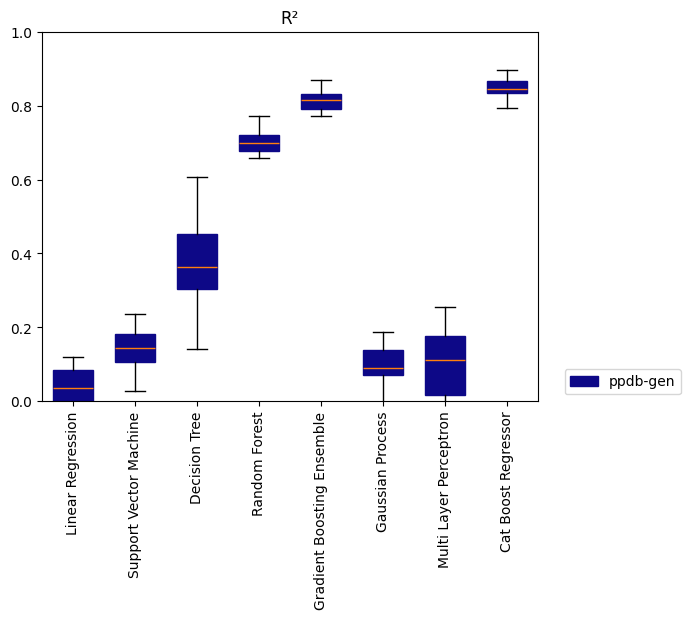

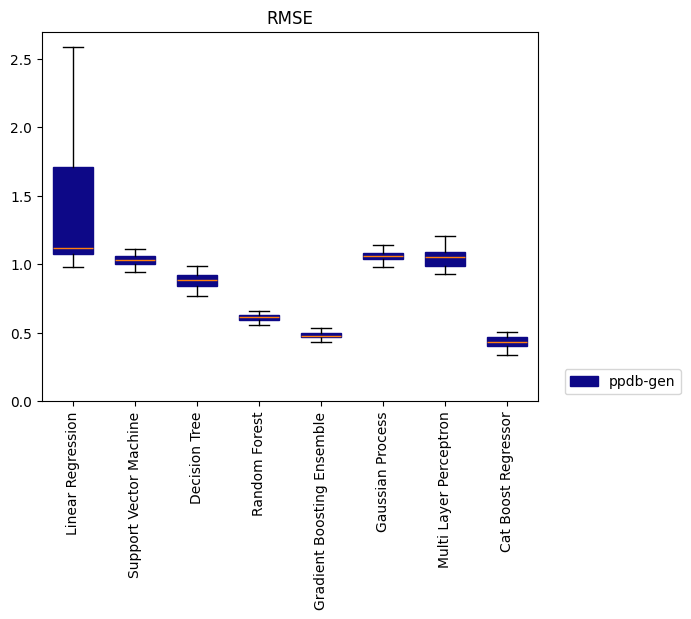

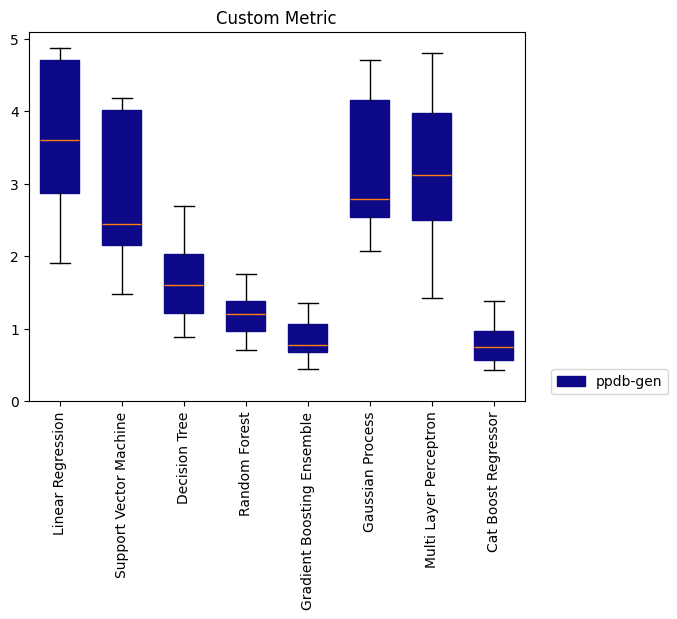

In [18]:
vis.cross_val(datasets_results, save_to=save_dir)